In [57]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import os
import fnmatch
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from dask.diagnostics import ProgressBar
from IPython.display import clear_output
from src.project_configs import *
from src.plotting import *
from src.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
pcs = load_gsam_pcs()
r = compute_r(pcs)
phase = compute_phase_number(compute_theta(pcs))
phase = phase.where((0.5<=r), 0)

In [67]:
initial_phase = phase.isel(time=slice(None, -1))
final_phase = phase.isel(time=slice(1, None))
assert(initial_phase.shape==final_phase.shape)

In [68]:
def get_var_moisture_sorted_files(var, lati, loni, timei):
    path=f'/glade/u/home/pangulo/work/gsam_dyamond_winter/northwest_tropical_pacific/{var}_moisture_space_grids_50pix'
    time_range = pd.date_range('2020-02-01', '2020-03-01', freq='3h')
    file_times = [time.strftime('%Y%m%d%H%M%S') for time in time_range[timei]]
    file_patterns = [path+f"/satfrac_sorted.lon_{int(lon)}.lat_{int(lat)}.northwest_tropical_pacific.DYAMOND2_9216x4608x74_10s_4608_{time}_*.nc" for lon, lat, time in zip(loni, lati, file_times)]
    files = []
    for i, f in enumerate(file_patterns):
        clear_output(wait=True)
        print(f'{100*i/len(file_patterns):.2f}%')
        found_files = glob(f)
        assert(len(found_files)==1)
        files.extend(found_files)
    return(files)

# Record file names in text files

In [69]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for p in [4,5,6]:
    # ids will be tuple of arrays (timei, lati, loni)
    persisting_time_id, persisting_lat_id, persisting_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p))
    regressing_time_id, regressing_lat_id, regressing_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p - 1))
    advancing_time_id, advancing_lat_id, advancing_lon_id = np.where((initial_phase.data == p) & (final_phase.data == p + 1))
    print('-'*10)
    print(f"Phase {p}")
    print(f"Number of persisting files: {persisting_time_id.size}")
    print(f"Number of regressing files: {regressing_time_id.size}")
    print(f"Number of advancing files: {advancing_time_id.size}")
    print('-'*10)
    timei_list = [persisting_time_id, advancing_time_id, regressing_time_id]
    lati_list = [persisting_lat_id, advancing_lat_id, regressing_lat_id]
    loni_list = [persisting_lon_id, advancing_lon_id, regressing_lon_id]
    for n, timei, lati, loni in zip(name, timei_list, lati_list, loni_list):
        files = get_var_moisture_sorted_files(var, lati, loni, timei)
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'w') as f:
            for file in files:
                f.write(f"{file}\n")

99.24%


# Read files in and compute mean streamfunction

## Circulation composite

In [71]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        clear_output(wait=True)
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        ds = xr.open_mfdataset(files, concat_dim='scene', combine='nested')
        w = ds.W
        w_mean = w.mean('column')
        w_anom = w - w_mean
        circ = w_anom.sel(z=slice(None, 17e3)).cumsum('column')
        with ProgressBar():
            circ.mean('scene').to_netcdf(f'{data_dir()}/phase{p}.{n}.circulation.nc')

persisting Phase 4
Found 841 files


KeyboardInterrupt: 

## Minimum streamfunction

In [6]:
var = 'W'
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]
        print(f'Found {len(files)} files')
        ds = xr.open_mfdataset(files, concat_dim='scene', combine='nested')
        w = ds.W
        w_mean = w.mean('column')
        w_anom = w - w_mean
        circ = w_anom.sel(z=slice(None, 17e3)).cumsum('column')
        with ProgressBar():
            circ.min(('column', 'z')).to_netcdf(f'{data_dir()}/phase{p}.{n}.min_psi.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 4.29 sms
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 2.46 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 1.54 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 2.66 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 2.05 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 1.96 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 1.85 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 932.39 ms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 425.23 ms


# Read files in and compute cloud fraction (based on $QC+QI>10^{-5}$ kg/kg)

In [72]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        qc = xr.open_mfdataset([_.replace('W', 'QC') for _ in files], concat_dim='scene', combine='nested').QC
        qi = xr.open_mfdataset([_.replace('W', 'QI') for _ in files], concat_dim='scene', combine='nested').QI
        qcpi = (1e-3*qc) + (1e-3*qi)
        cloud_frac = (qcpi>1e-5)
        
        with ProgressBar():
             (cloud_frac.sum('scene')/cloud_frac.scene.size).to_netcdf(f'{data_dir()}/phase{p}.{n}.cloudfrac.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 7.12 sms
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 4.79 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 2.66 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 3.99 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 3.47 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 3.18 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 2.96 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 1.97 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 1.04 sms


# Read files and compute 2D variables

In [27]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        surf_ds = xr.open_mfdataset([_.replace('W', '2D').replace('_2D.atm.3D', '.2D_atm') for _ in files], concat_dim='scene', combine='nested')     
        with ProgressBar():
             (surf_ds.Prec.mean('scene')).to_netcdf(f'{data_dir()}/phase{p}.{n}.prec.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 12.41 s
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 7.94 sms
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 3.87 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 6.93 sms
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 6.10 sms
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 5.30 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 4.78 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 1.25 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 327.59 ms


In [163]:
name = ['persisting', 'advancing', 'regressing']
for n in name:
    for p in [4,5,6]:
        print(f'{n} Phase {p}')
        with open(f'{data_dir()}/phase{p}.{n}.txt', 'r') as f:
            files = [line.strip() for line in f]

        print(f'Found {len(files)} files')
        surf_ds = xr.open_mfdataset([_.replace('W', '2D').replace('_2D.atm.3D', '.2D_atm') for _ in files], concat_dim='scene', combine='nested')
       
        
        with ProgressBar():
             (surf_ds.Prec.std()/np.sqrt(len(files))).to_netcdf(f'{data_dir()}/phase{p}.{n}.prec_se.nc')

persisting Phase 4
Found 841 files
[########################################] | 100% Completed | 34.73 s
persisting Phase 5
Found 475 files
[########################################] | 100% Completed | 13.17 s
persisting Phase 6
Found 311 files
[########################################] | 100% Completed | 6.77 sms
advancing Phase 4
Found 466 files
[########################################] | 100% Completed | 12.74 s
advancing Phase 5
Found 394 files
[########################################] | 100% Completed | 9.58 ss
advancing Phase 6
Found 362 files
[########################################] | 100% Completed | 8.75 sms
regressing Phase 4
Found 346 files
[########################################] | 100% Completed | 7.65 sms
regressing Phase 5
Found 192 files
[########################################] | 100% Completed | 3.47 sms
regressing Phase 6
Found 131 files
[########################################] | 100% Completed | 639.25 ms


# Comparing minimum streamfunctions between phases

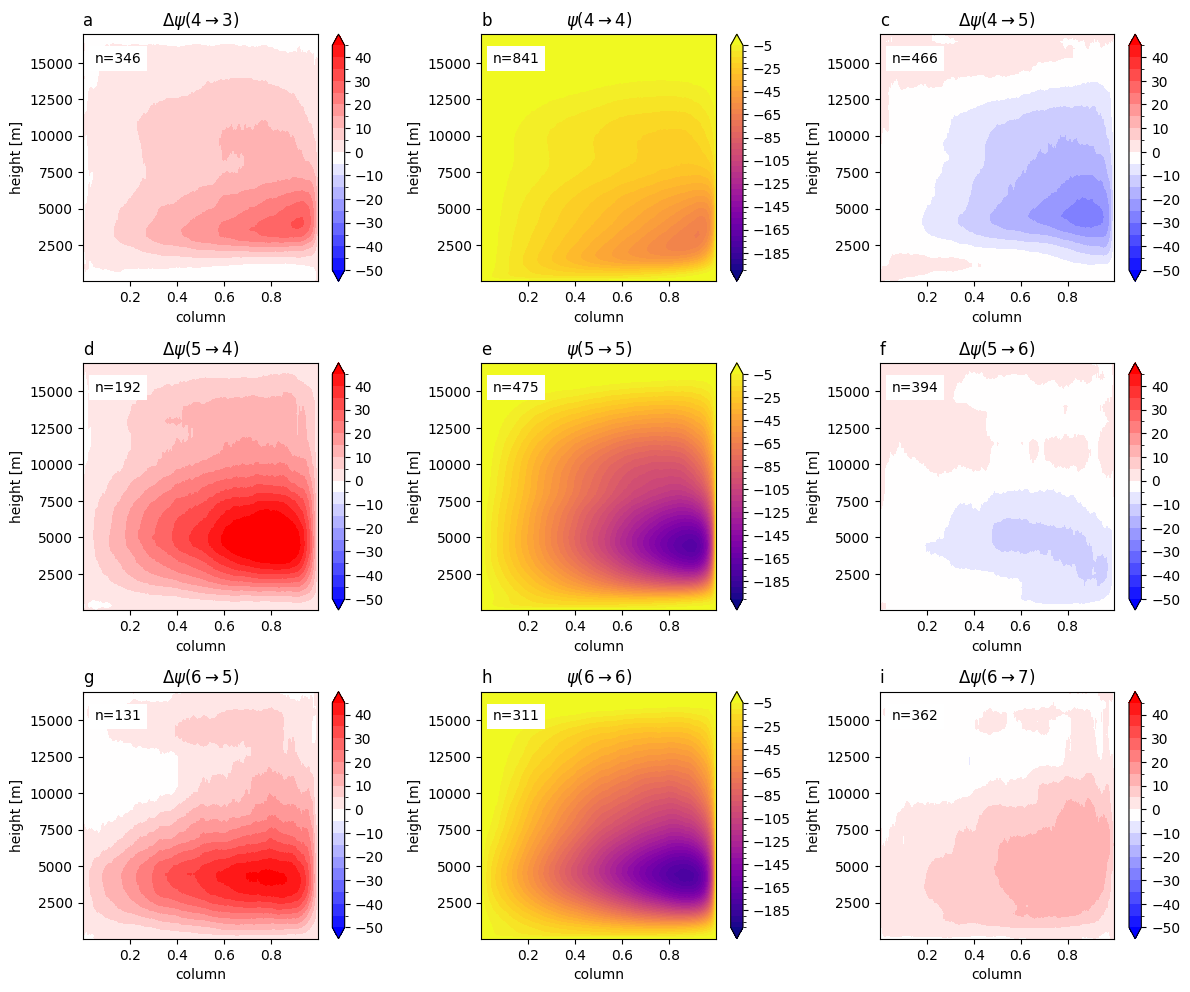

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
for i, p in enumerate([4,5,6]):
    persist = load_composite_circulation('persisting', p)
    advancing = load_composite_circulation('advancing', p)
    regressing = load_composite_circulation('regressing', p)

    ax = axs[i, 1]
    persist.coarsen({'column': 5}).mean().plot.contourf(ax=ax, cmap=plt.cm.plasma, levels=np.arange(-200, 0, 5), extend='both', cbar_kwargs={'label': None})
    ax.set_title(rf'$\psi({p}\rightarrow {p}$)')
    ax.set_title(chr(ord('b') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))

    ax = axs[i, 0]
    (regressing-persist).coarsen({'column': 5}).mean().plot.contourf(ax=ax, cmap=plt.cm.bwr, levels=np.arange(-50, 50, 5), extend='both', cbar_kwargs={'label': None})
    ax.set_title(rf'$\Delta\psi({p}\rightarrow {p-1}$)')
    ax.set_title(chr(ord('a') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p-1))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))
    
    ax = axs[i, 2]
    (advancing-persist).coarsen({'column': 5}).mean().plot.contourf(ax=ax, cmap=plt.cm.bwr, levels=np.arange(-50, 50, 5), extend='both', cbar_kwargs={'label': None})
    ax.set_title(rf'$\Delta\psi({p}\rightarrow {p+1}$)')
    ax.set_title(chr(ord('c') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p+1))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))
    
fig.tight_layout(pad=1)
save_figure(fig, 'circulation_differences.pdf')

# Differences to MSE, etc

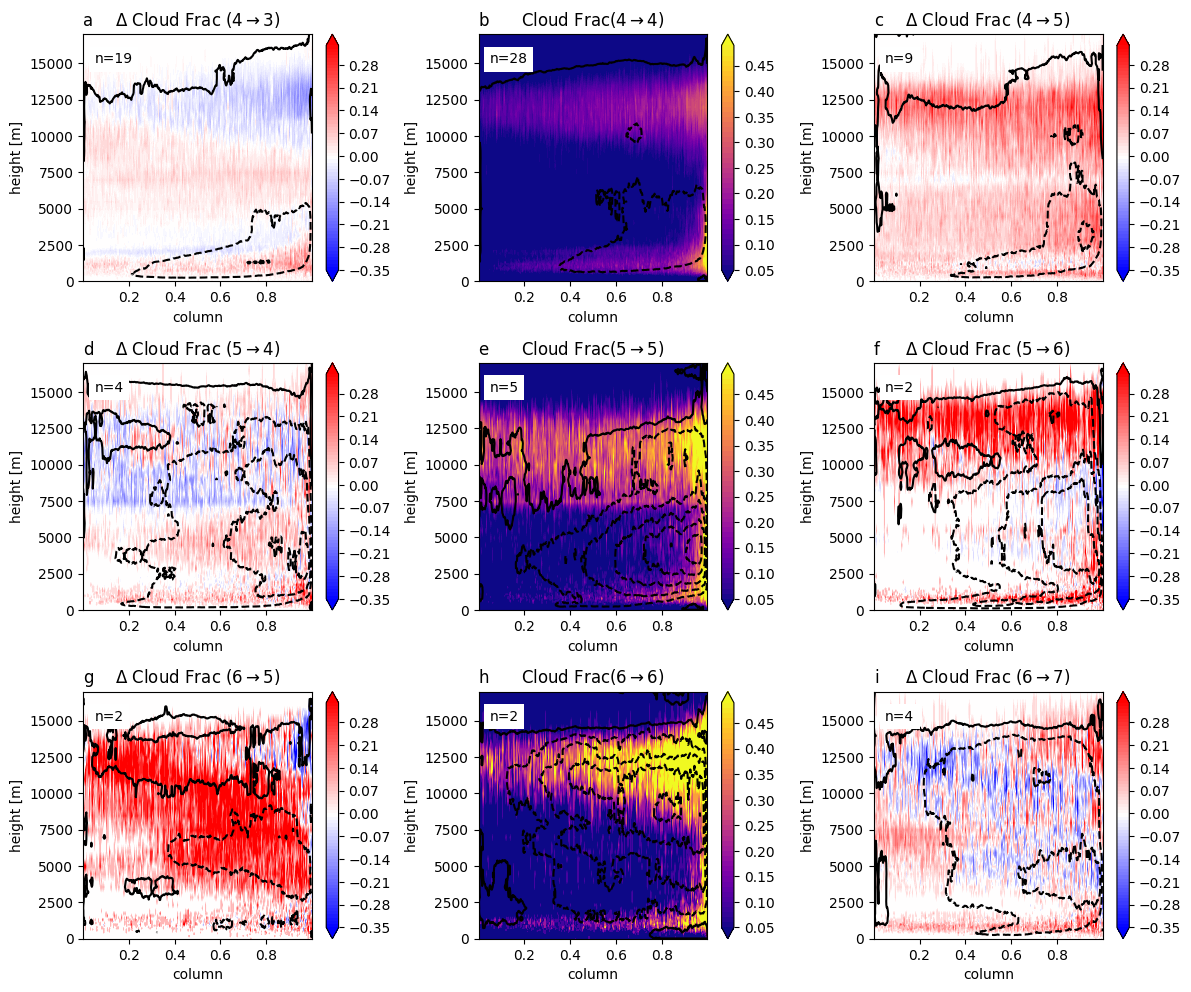

In [64]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
for i, p in enumerate([4,5,6]):
    persisting_circulation = load_composite_circulation('persisting', p).coarsen({'column': 5}).mean()
    persisting_cloudfrac = load_composite_cloudfraction('persisting', p).coarsen({'column': 5}).mean()
    advancing_circulation = load_composite_circulation('advancing', p).coarsen({'column': 5}).mean()
    advancing_cloudfrac = load_composite_cloudfraction('advancing', p).coarsen({'column': 5}).mean()
    regressing_circulation = load_composite_circulation('regressing', p).coarsen({'column': 5}).mean()
    regressing_cloudfrac = load_composite_cloudfraction('regressing', p).coarsen({'column': 5}).mean()

    ax = axs[i, 1]
    persisting_circulation.plot.contour(ax=ax, levels=np.linspace(-150, 0, 10), colors='black')
    levels = np.arange(0.05, 0.5, 0.01)
    norm = colors.Normalize(vmin=levels.min(), vmax=levels.max())
    persisting_cloudfrac.plot.contourf(ax=ax, levels=levels, cmap=plt.cm.plasma, norm=norm)
    ax.set_title(rf'Cloud Frac$({p}\rightarrow {p}$)')
    ax.set_title(chr(ord('b') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))
    ax.set_ylim(0, 17e3)

    ax = axs[i, 0]
    regressing_circulation.plot.contour(ax=ax, levels=np.linspace(-150, 0, 10), colors='black')
    levels = np.arange(-0.35, 0.35, 0.01)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    (regressing_cloudfrac-persisting_cloudfrac).plot.contourf(ax=ax, levels=levels, cmap=plt.cm.bwr, norm=norm, extend='both')
    ax.set_title(rf'$\Delta$ Cloud Frac $({p}\rightarrow {p-1}$)')
    ax.set_title(chr(ord('a') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p-1))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))
    ax.set_ylim(0, 17e3)
    
    ax = axs[i, 2]
    advancing_circulation.plot.contour(ax=ax, levels=np.linspace(-150, 0, 10), colors='black')
    levels = np.arange(-0.35, 0.35, 0.01)
    norm = colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max())
    (advancing_cloudfrac-regressing_cloudfrac).plot.contourf(ax=ax, levels=levels, cmap=plt.cm.bwr, norm=norm, extend='both')
    ax.set_title(rf'$\Delta$ Cloud Frac $({p}\rightarrow {p+1}$)')
    ax.set_title(chr(ord('c') + (i*3)), loc='left')
    n = len(np.where((initial_phase.data == p) & (final_phase.data == p+1))[0])
    ax.text(0.05, 15e3, f'n={n}', bbox=dict(facecolor='white', edgecolor='none'))
    ax.set_ylim(0, 17e3)
fig.tight_layout(pad=1)
save_figure(fig, 'cloudfrac_differences.pdf')

# Different precipitations

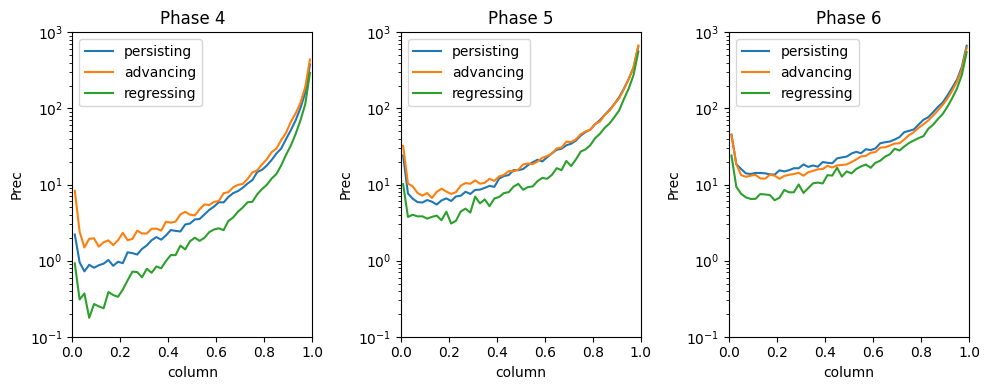

In [48]:
import numpy as np

fig, axs = plt.subplots(ncols=3, figsize=(10, 4))
for i, p in enumerate([4,5,6]):
    ax = axs[i]
    for n in ['persisting', 'advancing', 'regressing']:
        pr = load_composite_prec(n, p).coarsen({'column': 50}).mean()
        pr.plot(ax=ax, label=n)
        ax.set_xlim(0, 1)
        ax.set_ylim(1e-1, 1e3)
# Add legends and titles
for i, p in enumerate([4,5,6]):
    axs[i].set_title(f'Phase {p}')
    axs[i].legend()
    axs[i].set_xlabel('column')
    axs[i].set_yscale('log')
plt.tight_layout()
plt.show()


In [12]:
min_psi

<xarray.DataArray 'W' (scene: 346)> Size: 1kB
[346 values with dtype=float32]
Dimensions without coordinates: scene

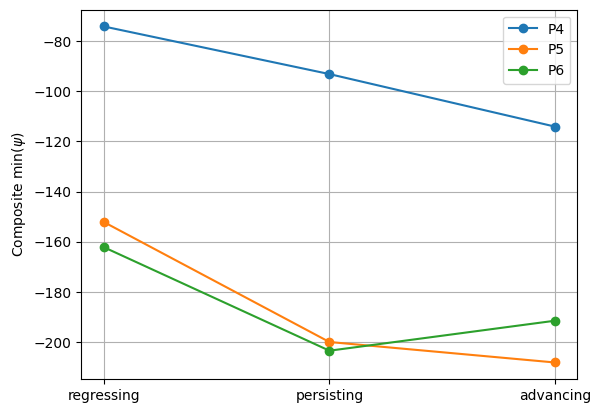

In [207]:
fig, ax = plt.subplots()
for i, p in enumerate([4,5,6]):
    mean_list = []
    upper_list = []
    lower_list = []
    for n in ['regressing', 'persisting', 'advancing']:
        mean_list.append(load_composite_min_psi(n,p))
        
    ax.plot([1, 2, 3], mean_list, marker='o', label=f'P{p}')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['regressing', 'persisting', 'advancing'])
ax.set_ylabel(r'Composite min($\psi$)')
ax.legend()
ax.grid()

In [ ]:
fig, ax = plt.subplots()
for i, p in enumerate([4,5,6]):
    mean_list = []
    upper_list = []
    lower_list = []
    for n in ['regressing', 'persisting', 'advancing']:
        mean_list.append(load_composite_min_psi(n,p))
        
    ax.plot([1, 2, 3], mean_list, marker='o', label=f'P{p}')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['regressing', 'persisting', 'advancing'])
ax.set_ylabel(r'Composite min($\psi$)')
ax.legend()
ax.grid()